# Statistical study of changing Mass model paramter(s) 

* In this notebook I will show the effect of changing mass model parameter on the detectable gravitational waves (GW) event rates per year

### Binary Black Hole (BBH) Mass Model

* I will use the power-law+peak mass model and change the slope of the power-law component ($\alpha$) on the mass function.

* Here is the default parameters and resultant distribution of the chosen mass model:

<table>
<tr>
<td>

| Parameter            | Value  |
|----------------------|--------|
| $m_{\text{minbh}}$   | 4.98   |
| $m_{\text{maxbh}}$   | 112.5  |
| $\alpha$             | 3.78   |
| $\mu_g$              | 32.27  |
| $\sigma_g$           | 3.88   |
| $\lambda_{\text{peak}}$ | 0.03 |
| $\delta_m$           | 4.8    |
| $\beta$              | 0.81   |

</td>
<td>

![mass_bbh](../../_static/bbh_mass.png)

</td>
</tr>
</table>

### Binary Neutron Star (BNS) Mass Model

* The mass distribution of neutron stars in binary neutron star (BNS) systems can be characterized by a bimodal distribution, which can be modeled using a double Gaussian distribution. Each normal distribution is independently truncated and normalized in the range [1, 2.3] $M_{\odot}$, ensuring that the neutron star masses are within the physically plausible range. 

*  This bimodal distribution is thought to reflect the different evolutionary paths that neutron stars can take. For more details, refer to [Alsing et al. 2018](https://arxiv.org/pdf/1805.06442.pdf) and [M. Farr et al. 2020](https://arxiv.org/pdf/2005.00032.pdf).

* I will change the maximum cut ($m_{\text{max}}$) on the mass function.

* Here is the default parameters and resultant distribution of the chosen mass model:

<table>
<tr>
<td>

| Parameter   | Value            |
|-------------|------------------|
| $w$         | 0.643            |
| $\mu_L$     | 1.352 $M_{\odot}$|
| $\sigma_L$  | 0.08 $M_{\odot}$ |
| $\mu_R$     | 1.88 $M_{\odot}$ |
| $\sigma_R$  | 0.3 $M_{\odot}$  |
| $m_{\text{max}}$ | 2.3 $M_{\odot}$ |

</td>
<td>

![mass_bns](../../_static/bns_mass.png)

</td>
</tr>
</table>


## BBH

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from ler.rates import GWRATES

In [10]:
# # initialization
ler = GWRATES(verbose=False, event_type='BBH')

* When `LeR` class is initialized, the mass model is created with the default parameters. This is in the form of a interpolation and the parameters are fixed.

* I will change the function of the mass model with a default power-law+peak mass model and change the maximum cut ($m_{\text{maxbh}}$) on the mass function.

* Below I will providing an example. But first let me show you which models are available in the `ler`.

In [11]:
ler.available_gw_prior_list_and_its_params.keys()

dict_keys(['merger_rate_density', 'source_frame_masses', 'zs', 'spin', 'geocent_time', 'ra', 'phase', 'psi', 'theta_jn'])

In [12]:
ler.available_gw_prior_list_and_its_params['source_frame_masses']

{'binary_masses_BBH_popI_II_powerlaw_gaussian': {'mminbh': 4.98,
  'mmaxbh': 112.5,
  'alpha': 3.78,
  'mu_g': 32.27,
  'sigma_g': 3.88,
  'lambda_peak': 0.03,
  'delta_m': 4.8,
  'beta': 0.81},
 'binary_masses_BBH_popIII_lognormal': {'Mc': 30.0, 'sigma': 0.3, 'beta': 1.1},
 'binary_masses_BBH_primordial_lognormal': {'Mc': 30.0,
  'sigma': 0.3,
  'beta': 1.1},
 'binary_masses_BNS_gwcosmo': {'mminns': 1.0, 'mmaxns': 3.0, 'alphans': 0.0},
 'binary_masses_BNS_bimodal': {'w': 0.643,
  'muL': 1.352,
  'sigmaL': 0.08,
  'muR': 1.88,
  'sigmaR': 0.3,
  'mmin': 1.0,
  'mmax': 2.3}}

* changing mass function parameter $\alpha$ for sampling. Considered values are,
  * $\alpha = 3.78$: default value, from [GWTC-3 2021](https://arxiv.org/pdf/2111.03604.pdf) (page-23)
  * $\alpha = 2.63$: from [WIERDA et al. 2021](https://arxiv.org/pdf/2106.06303.pdf) (Appendix B)

* you can have only 'size' as input parameter

* These mass function returns the mass of the binary black hole in the unit of solar mass ($m_1$, $m_2$).

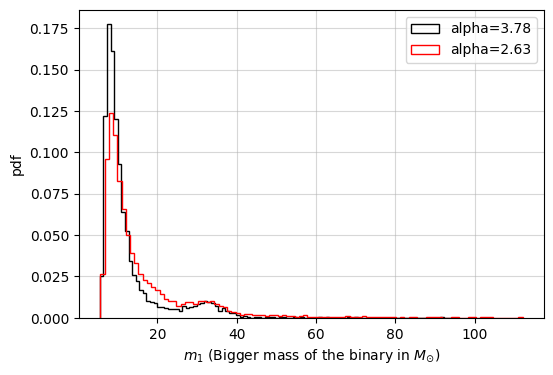

In [18]:
# with default value
ler.sample_source_frame_masses = lambda size: ler.binary_masses_BBH_popI_II_powerlaw_gaussian(size=size, alpha=3.78)

# plot 
plt.figure(figsize=(6, 4))
plt.hist(ler.sample_source_frame_masses(10000)[0], bins=100, histtype='step', color='k', density=True, label='alpha=3.78')

# with custom value
ler.sample_source_frame_masses = lambda size: ler.binary_masses_BBH_popI_II_powerlaw_gaussian(size=size, alpha=2.63)

# plot
plt.hist(ler.sample_source_frame_masses(10000)[0], bins=100, histtype='step', color='r', density=True, label='alpha=2.63')
plt.xlabel(r'$m_1$ (Bigger mass of the binary in $M_{\odot}$)')
plt.ylabel('pdf')

plt.legend()
plt.grid(alpha=0.5)
plt.show()

* let's make a range of $\alpha$ between the two values

### Calculation of rates (per year)

In [15]:
alpha_arr = np.linspace(2.63, 3.78, 10)
gw_rates = np.zeros_like(alpha_arr)
sample_size = 1000000  # increase the sample size to 1 million for better statistics
ler.batch_size = 100000

# let's suppress some of the print outputs
import contextlib

for i, alpha in enumerate(alpha_arr):
    print("\n iteration: ", i)
    ler.sample_source_frame_masses = lambda size: ler.binary_masses_BBH_popI_II_powerlaw_gaussian(size=size, alpha=alpha)

    # un-lensed
    with contextlib.redirect_stdout(None):  # suppress print output
        ler.gw_cbc_statistics(size=sample_size);
        rate,_ = ler.gw_rate(output_jsonfile="gw_param_detectable_"+str(i)+".json")
    gw_rates[i] = rate
    print(f'gw rate per year (alpha={alpha}): {rate}')


 iteration:  0
gw rate per year (alpha=2.63): 602.399735152594

 iteration:  1
gw rate per year (alpha=2.7577777777777777): 583.6620908730581

 iteration:  2
gw rate per year (alpha=2.8855555555555554): 541.7353177613893

 iteration:  3
gw rate per year (alpha=3.013333333333333): 516.4757309978161

 iteration:  4
gw rate per year (alpha=3.141111111111111): 500.0155904428646

 iteration:  5
gw rate per year (alpha=3.2688888888888887): 490.69852975138264

 iteration:  6
gw rate per year (alpha=3.3966666666666665): 471.8573625752747

 iteration:  7
gw rate per year (alpha=3.5244444444444443): 465.12837429809326

 iteration:  8
gw rate per year (alpha=3.652222222222222): 447.6330047774216

 iteration:  9
gw rate per year (alpha=3.78): 430.13763525675


gw rate: slope=-143.657045929216, intercept=965.3951693918017, r_value=-0.9795941702168517, p_value=7.401514058755967e-07, std_err=10.420797560559112


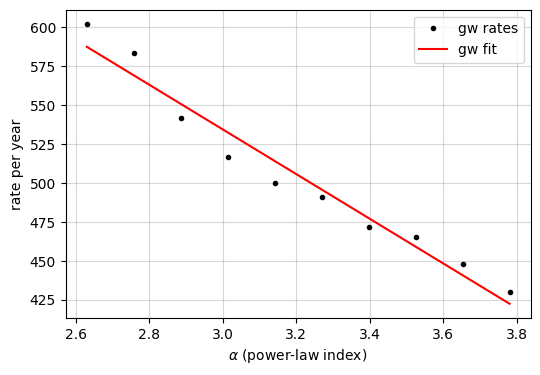

In [19]:
# linear fit to the rates
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(alpha_arr, gw_rates)
print(f'gw rate: slope={slope}, intercept={intercept}, r_value={r_value}, p_value={p_value}, std_err={std_err}')


# gw_rates vs alpha
plt.figure(figsize=(6, 4))
plt.plot(alpha_arr, gw_rates, 'k.', label='gw rates')
plt.plot(alpha_arr, slope*alpha_arr + intercept, 'r-', label='gw fit')
plt.xlabel(r'$\alpha$ (power-law index)')
plt.ylabel('rate per year')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

* The change in rate is significant and has a decreasing trend as $\alpha$ increases.

* Increasing the value of $\alpha$ results in more BBH events is mass range [15, 30] $M_{\odot}$

* You can repeat the same test for other parameters as well.

* You can repeat the same test for 3G detectors as well.

## BNS

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from ler.rates import GWRATES

In [25]:
# # initialization
ler = GWRATES(verbose=False, event_type='BNS')

In [26]:
ler.available_gw_prior_list_and_its_params['source_frame_masses']

{'binary_masses_BBH_popI_II_powerlaw_gaussian': {'mminbh': 4.98,
  'mmaxbh': 112.5,
  'alpha': 3.78,
  'mu_g': 32.27,
  'sigma_g': 3.88,
  'lambda_peak': 0.03,
  'delta_m': 4.8,
  'beta': 0.81},
 'binary_masses_BBH_popIII_lognormal': {'Mc': 30.0, 'sigma': 0.3, 'beta': 1.1},
 'binary_masses_BBH_primordial_lognormal': {'Mc': 30.0,
  'sigma': 0.3,
  'beta': 1.1},
 'binary_masses_BNS_gwcosmo': {'mminns': 1.0, 'mmaxns': 3.0, 'alphans': 0.0},
 'binary_masses_BNS_bimodal': {'w': 0.643,
  'muL': 1.352,
  'sigmaL': 0.08,
  'muR': 1.88,
  'sigmaR': 0.3,
  'mmin': 1.0,
  'mmax': 2.3}}

binary_masses_BNS_bimodal interpolator will be loaded from ./interpolator_pickle/binary_masses_BNS_bimodal/binary_masses_BNS_bimodal_0.pickle
binary_masses_BNS_bimodal interpolator will be loaded from ./interpolator_pickle/binary_masses_BNS_bimodal/binary_masses_BNS_bimodal_1.pickle


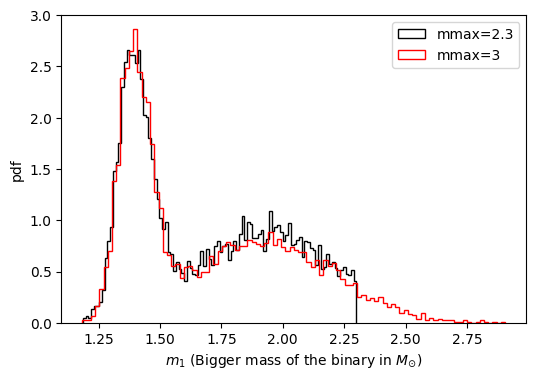

In [27]:
# with default value
ler.sample_source_frame_masses = lambda size: ler.binary_masses_BNS_bimodal(size=size, mmax=2.3)

# plot 
plt.figure(figsize=(6, 4))
plt.hist(ler.sample_source_frame_masses(10000)[0], bins=100, histtype='step', color='k', density=True, label='mmax=2.3')

# with custom value
ler.sample_source_frame_masses = lambda size: ler.binary_masses_BNS_bimodal(size=size, mmax=3)

# plot
plt.hist(ler.sample_source_frame_masses(10000)[0], bins=100, histtype='step', color='r', density=True, label='mmax=3')
plt.xlabel(r'$m_1$ (Bigger mass of the binary in $M_{\odot}$)')
plt.ylabel('pdf')

plt.legend()
plt.show()

### Un-lensed

In [30]:
mmax_arr = np.linspace(2.3, 3, 5)
gw_rates_bns = np.zeros_like(mmax_arr)
sample_size = 2000000  # increase the sample size to 2 million for better statistics
ler.batch_size = 100000

# let's suppress some of the print outputs
import contextlib

for i, mmax in enumerate(mmax_arr):
    print("\n iteration: ", i)
    ler.sample_source_frame_masses = lambda size: ler.binary_masses_BNS_bimodal(size=size, mmax=mmax)

    # un-lensed
    with contextlib.redirect_stdout(None):  # suppress print output
        ler.gw_cbc_statistics(size=sample_size);
        rate,_ = ler.gw_rate(output_jsonfile="gw_param_bns_detectable_"+str(i)+".json")
    gw_rates_bns[i] = rate
    print(f'gw rate (mmax={mmax}): {rate}')


 iteration:  0
gw rate (mmax=2.3): 1.9669350348684111

 iteration:  1
gw rate (mmax=2.4749999999999996): 2.898641104016606

 iteration:  2
gw rate (mmax=2.65): 2.5880724143005414

 iteration:  3
gw rate (mmax=2.825): 3.8821086214508123

 iteration:  4
gw rate (mmax=3.0): 2.691595310872563


gw rate: slope=1.3901646111100057, intercept=-0.8784657223397283, r_value=0.5535928457320664, p_value=0.33301505236005835, std_err=1.2073948295286805


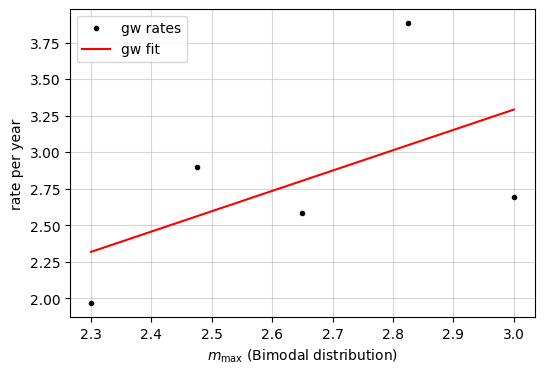

In [33]:
# linear fit to the rates
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(mmax_arr, gw_rates_bns)
print(f'gw rate: slope={slope}, intercept={intercept}, r_value={r_value}, p_value={p_value}, std_err={std_err}')

# gw_rates vs mmax
plt.figure(figsize=(6, 4))
plt.plot(mmax_arr, gw_rates_bns, 'k.', label='gw rates')
plt.plot(mmax_arr, slope*mmax_arr + intercept, 'r-', label='gw fit')
plt.xlabel(r'$m_{\max}$ (Bimodal distribution)')
plt.ylabel('rate per year')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

* rate and $m_max$ does not have a strong linear relationship, but an increasing trend is observed.

* The rate is higher for higher $m_{\text{max}}$ values. This is because higher mass BBHs have higher SNRs and are detectable at larger distances.

In [1]:
from astropy.cosmology import Planck18

# Accessing cosmological parameters
H0 = Planck18.H0
Om0 = Planck18.Om0
Ode0 = Planck18.Ode0

print(f"Hubble constant (H0): {H0}")
print(f"Matter density parameter (Om0): {Om0}")
print(f"Dark energy density parameter (Ode0): {Ode0}")


Hubble constant (H0): 67.66 km / (Mpc s)
Matter density parameter (Om0): 0.30966
Dark energy density parameter (Ode0): 0.6888463055445441


In [2]:
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)

# Accessing cosmological parameters
H0 = cosmo.H0
Om0 = cosmo.Om0
Ode0 = cosmo.Ode0

print(f"Hubble constant (H0): {H0}")
print(f"Matter density parameter (Om0): {Om0}")
print(f"Dark energy density parameter (Ode0): {Ode0}")

Hubble constant (H0): 70.0 km / (Mpc s)
Matter density parameter (Om0): 0.3
Dark energy density parameter (Ode0): 0.7
